# Custom CNN architecture

In [1]:
# Run the previous notebook to load all its classes and functions
%run busi_augmentation_2.ipynb

Found 133 images and 133 masks in normal folder


Processing normal masks: 100%|██████████████████████████████████████████████████████| 133/133 [00:00<00:00, 300.44it/s]


Dataset shape: (133, 224, 224, 1)
Masks shape: (133, 224, 224, 1)
Labels shape: (133,)
Class distribution: Normal: 133, Benign: 0, Malignant: 0
Training set sizes: X_train: (93, 224, 224, 1), y_train: (93,), masks: (93, 224, 224, 1)
Augmented training set sizes: X_aug: (558, 224, 224, 1), y_aug: (558,), masks: (558, 224, 224, 1)
Validation set sizes: X_val: (20, 224, 224, 1), y_val: (20,), masks: (20, 224, 224, 1)
Test set sizes: X_test: (20, 224, 224, 1), y_test: (20,), masks: (20, 224, 224, 1)
Found 437 images and 454 masks in benign folder


Processing benign masks: 100%|██████████████████████████████████████████████████████| 454/454 [00:00<00:00, 626.47it/s]


Combined 2 masks for benign (100).png
Combined 2 masks for benign (163).png
Combined 2 masks for benign (173).png
Combined 2 masks for benign (181).png
Combined 3 masks for benign (195).png
Combined 2 masks for benign (25).png
Combined 2 masks for benign (315).png
Combined 2 masks for benign (346).png
Combined 2 masks for benign (4).png
Combined 2 masks for benign (424).png
Combined 2 masks for benign (54).png
Combined 2 masks for benign (58).png
Combined 2 masks for benign (83).png
Combined 2 masks for benign (92).png
Combined 2 masks for benign (93).png
Combined 2 masks for benign (98).png
Dataset shape: (437, 224, 224, 1)
Masks shape: (437, 224, 224, 1)
Labels shape: (437,)
Class distribution: Normal: 0, Benign: 437, Malignant: 0
Training set sizes: X_train: (305, 224, 224, 1), y_train: (305,), masks: (305, 224, 224, 1)
Augmented training set sizes: X_aug: (610, 224, 224, 1), y_aug: (610,), masks: (610, 224, 224, 1)
Validation set sizes: X_val: (66, 224, 224, 1), y_val: (66,), masks

Processing malignant masks: 100%|███████████████████████████████████████████████████| 211/211 [00:00<00:00, 604.43it/s]


Combined 2 masks for malignant (53).png
Dataset shape: (210, 224, 224, 1)
Masks shape: (210, 224, 224, 1)
Labels shape: (210,)
Class distribution: Normal: 0, Benign: 0, Malignant: 210
Training set sizes: X_train: (147, 224, 224, 1), y_train: (147,), masks: (147, 224, 224, 1)
Augmented training set sizes: X_aug: (588, 224, 224, 1), y_aug: (588,), masks: (588, 224, 224, 1)
Validation set sizes: X_val: (31, 224, 224, 1), y_val: (31,), masks: (31, 224, 224, 1)
Test set sizes: X_test: (32, 224, 224, 1), y_test: (32,), masks: (32, 224, 224, 1)
(1756, 224, 224, 1)
(1756,)
(1756, 224, 224, 1)
Augmented images saved to: C:/Users/DragosTrandafiri/BreastCancer_CNN/data/processed/busi/processed_images_augmented/X


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Flatten,  Dropout, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import seaborn as sns
import time

In [3]:
print(X_aug.shape)
print(y_aug.shape)
print(masks_aug.shape)

(1756, 224, 224, 1)
(1756,)
(1756, 224, 224, 1)


# Apply normalization (suitable for custom CNNs)

This step is important because:
- we have features which are in a wide range (each pixels ranges from 0 to 255)
- we have to make them matter the same to the ML model
- prevent numerical instability
- normal distribution assumption

In [4]:
# Train
X_train_aug = X_aug.astype("float32") / 255.0
masks_train_aug = masks_aug.astype("float32") / 255.0
y_train_aug = y_aug

# Test
X_test = X_test.astype("float32") / 255.0
masks_test = masks_test.astype("float32") / 255.0
y_test = y_test

# Validation
X_val = X_val.astype("float32") / 255.0
masks_val = masks_val.astype("float32") / 255.0
y_val = y_val



## Explaining some concepts that we will use later

### CNNs
- specialized NNs designed for grid-like data
- automatically learn spacial hierarchies of features through convolution operations
- highly effective in tasks involving visual perception

### Convolutional layer
**Convolution** is a mathematical operation where a small filter (kernel) is systematically applied across an input (such as an image) to produce a feature map that captures important local patterns like edges, textures, or more complex structures.

- **number of filters** = how many different kernels does the layer apply? So we basically get **number of filters** different feature maps.
- As we go on through the layers of the model, we may need more and more different kernels to try, because we have more intricate patterns in the images.

- **kernel_size** = what is the size of the filter/kernels, helping us to detect edges like shapes, edges etc.

- **activation** = the activation function used

### Pooling layers

A pooling layer reduces the spatial dimentions(width and height) of a feature map by summarizing regions of th input, helping to decrease computation, control overfitting, and make the network more robust to small translations

Purpose:

- downsampling: reduces the size of feature maps;
- feature preservation: keeps the most important information
- translation invariance: small changes in input data do not change the pooled output much

### Max Pooling

Helps us detect the strongest activation, e.g. what feature is the most present. This way, we can detect more proeminent patterns and also improve computations.

### Fully Connected Layers

Learn from the high-level features extracted by convolutional and pooling layers

- **dropout** - during training, turns off a percent of neurons in the Dense layer, to prevent overfitting.

### ReLU Activation
- keeps patterns of the data, also getting rid of negative values
- neurons stuck with negative inputs stop updating (gradient = 0)
- most popular in modern NNs

### LeakyReLU 
- allows a small gradient when x < 0 → avoids dying ReLU.

### Batch size
- how many training samples the network processes before updating its weights during training. It influences both the model's performance and the computational efficiency.
- some mostly used values are 32, 64, 128 ...
- I chose 32 because it puts in balance the computational resources needed and the efficiency of the model



### Adam Optimizer

Adam (short for **Adaptive Moment Estimation**) is one of the most popular and effective optimization algorithms used to train deep learning models. Adam adapts the learning rate for each parameter individually using **first** and **second moments** of the gradients:

- The **first moment** is the **mean** of the gradient (like momentum).
- The **second moment** is the **uncentered variance** of the gradient.

This helps Adam:
- Converge faster
- Handle sparse gradients
  

# 1. Model from article

This is the implementation of the custom CNN from https://www.researchgate.net/publication/344611800_Convolutional_neural_network-based_models_for_diagnosis_of_breast_cancer. Let us see what results we get on our dataset.

In [7]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

In [10]:
model = Sequential([
    # Input layer (grayscale images 224x224x1)
    Input(shape=(224, 224, 1)),

    # Convolutional layer: 20 filters, kernel size 5x5
    Conv2D(20, (5, 5), padding="same"),
    
    # Batch Normalization (20 channels)
    BatchNormalization(),
    
    # ReLU activation
    Activation("relu"),
    
    # MaxPooling
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten before fully connected
    Flatten(),
    
    # Fully connected layer (let’s use 128 units)
    Dense(128, activation="relu"),
    
    # Dropout 50%
    Dropout(0.5),
    
    # Output layer with 3 classes
    Dense(3, activation="softmax")
])

In [11]:
# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 625ms/step - accuracy: 0.3468 - loss: 17.3159 - val_accuracy: 0.5641 - val_loss: 1.0979
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 623ms/step - accuracy: 0.3531 - loss: 1.0927 - val_accuracy: 0.5641 - val_loss: 1.0954
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 622ms/step - accuracy: 0.3525 - loss: 1.0926 - val_accuracy: 0.5641 - val_loss: 1.0928
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 622ms/step - accuracy: 0.3542 - loss: 1.0905 - val_accuracy: 0.5641 - val_loss: 1.0897
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 624ms/step - accuracy: 0.3531 - loss: 1.0917 - val_accuracy: 0.5641 - val_loss: 1.0881
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


We can see that maximum val_accuracy is ~55%, because the model is too simple and can not detect anomalies.

# 2. Custom CNNs (initial trials)

In [12]:
# Hyperparameter options

activations = [
    ("relu", "relu"),
    ("leakyrelu", LeakyReLU(negative_slope=0.01))
]
conv_base_filters =[32, 64, 128]


histories = []


for conv_base_filter in conv_base_filters:
    for activation_name, activation_fn in activations:
            print(
                f"Training model with: "
                f"activation={activation_name}, "
                f"conv_base_filter={conv_base_filter}"
            )
        
            #Apply early stopping to save time & avoid overfitting
            # Early stopping
            early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)


            # Model definition
            model = Sequential([
                Input(shape=(224, 224, 1)),
                Conv2D(conv_base_filter, kernel_size=(3,3), activation=activation_fn),
                MaxPooling2D(pool_size=(2, 2)),

                Conv2D(conv_base_filter*2, kernel_size=(3,3), activation=activation_fn),
                MaxPooling2D(pool_size=(2, 2)),

                Conv2D(conv_base_filter*4, kernel_size=(3,3), activation=activation_fn),
                MaxPooling2D(pool_size=(2, 2)),

                Flatten(),
                Dense(128, activation=activation_fn),
                Dropout(0.5),
                Dense(3, activation='softmax')
            ])

            # Compile
            model.compile(
                optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

            # Train
            history = model.fit(
                X_train_aug, y_train_aug,
                validation_data=(X_val, y_val),
                epochs=30,
                batch_size=32,
                callbacks=[early_stop]
            )

            # Save
            label = (
                f"conv_base_filter={conv_base_filter}, "
                f"activation={activation_name} "
            )
            histories.append((label, history))


Training model with: activation=relu, conv_base_filter=32
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 578ms/step - accuracy: 0.4374 - loss: 1.0787 - val_accuracy: 0.5812 - val_loss: 0.9606
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 574ms/step - accuracy: 0.6042 - loss: 0.8569 - val_accuracy: 0.6581 - val_loss: 0.8124
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 550ms/step - accuracy: 0.7597 - loss: 0.5998 - val_accuracy: 0.7094 - val_loss: 0.7387
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 600ms/step - accuracy: 0.8622 - loss: 0.3773 - val_accuracy: 0.7179 - val_loss: 0.7726
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 531ms/step - accuracy: 0.9123 - loss: 0.2462 - val_accuracy: 0.7009 - val_loss: 0.8043
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 525ms/step - accuracy: 0.9385 - loss: 0.1663 - val_accuracy: 0.7009 - val_loss: 0.9417
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.9607 - loss: 0.1191 - val_accuracy: 0.7179 - val_loss: 0.9195
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2

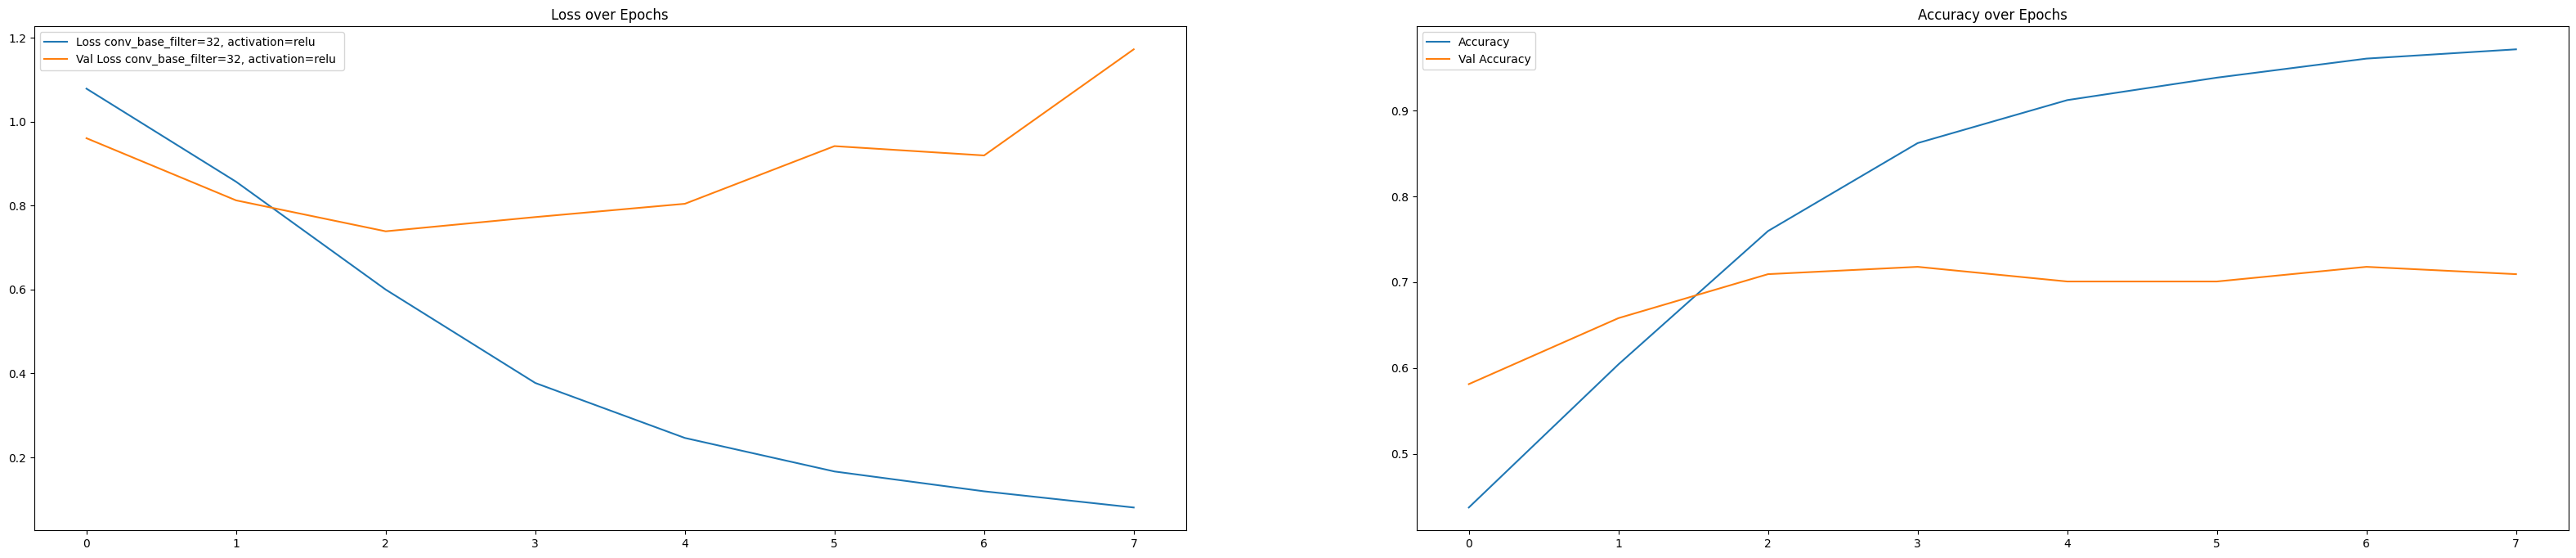

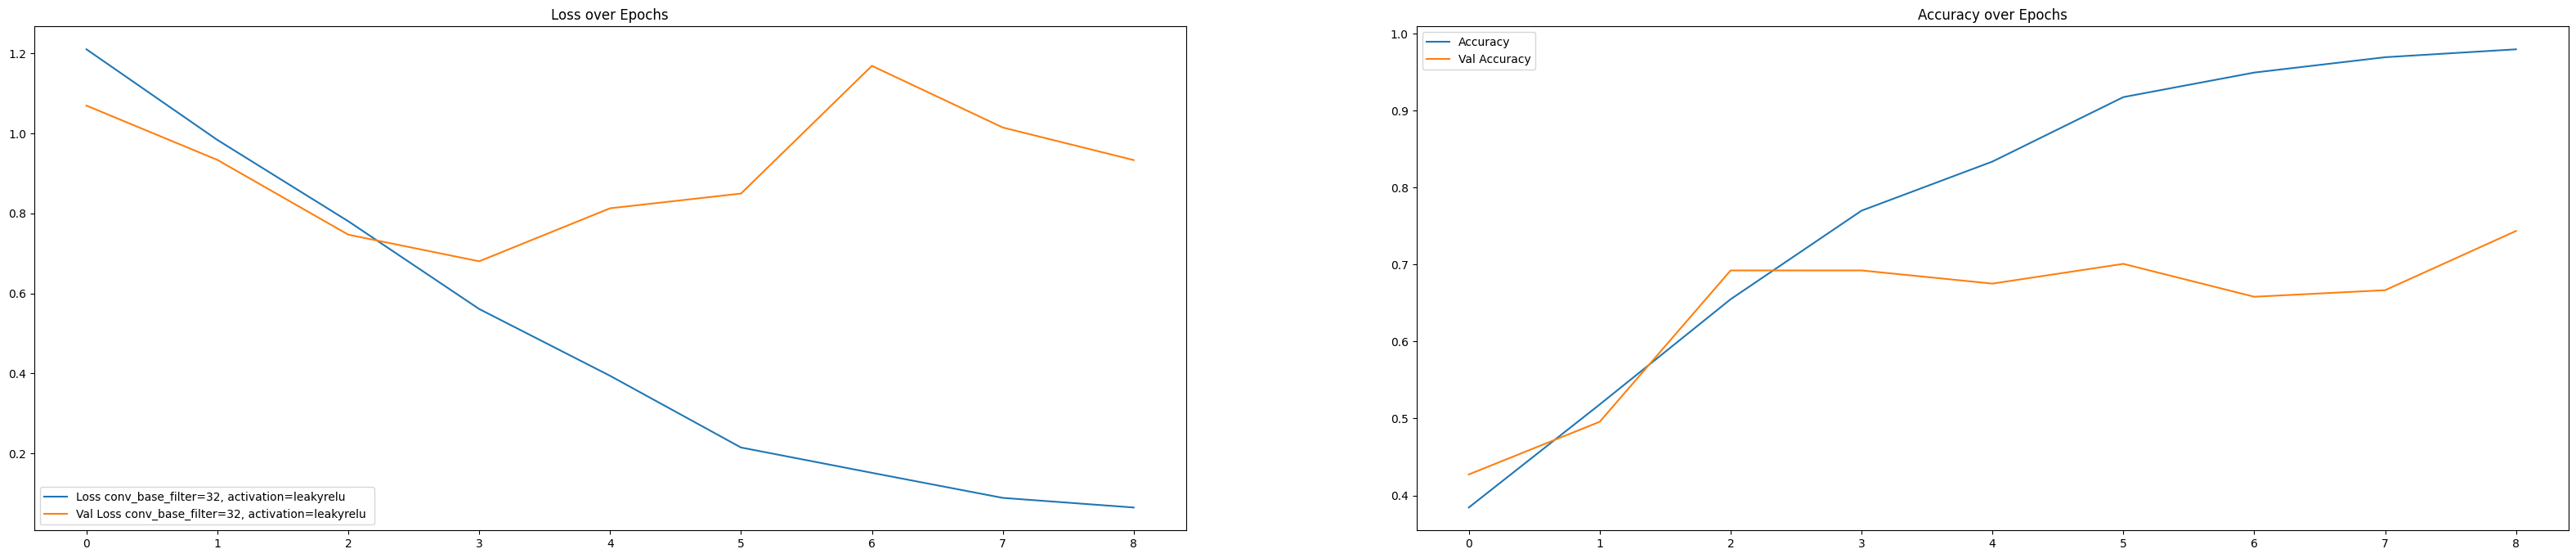

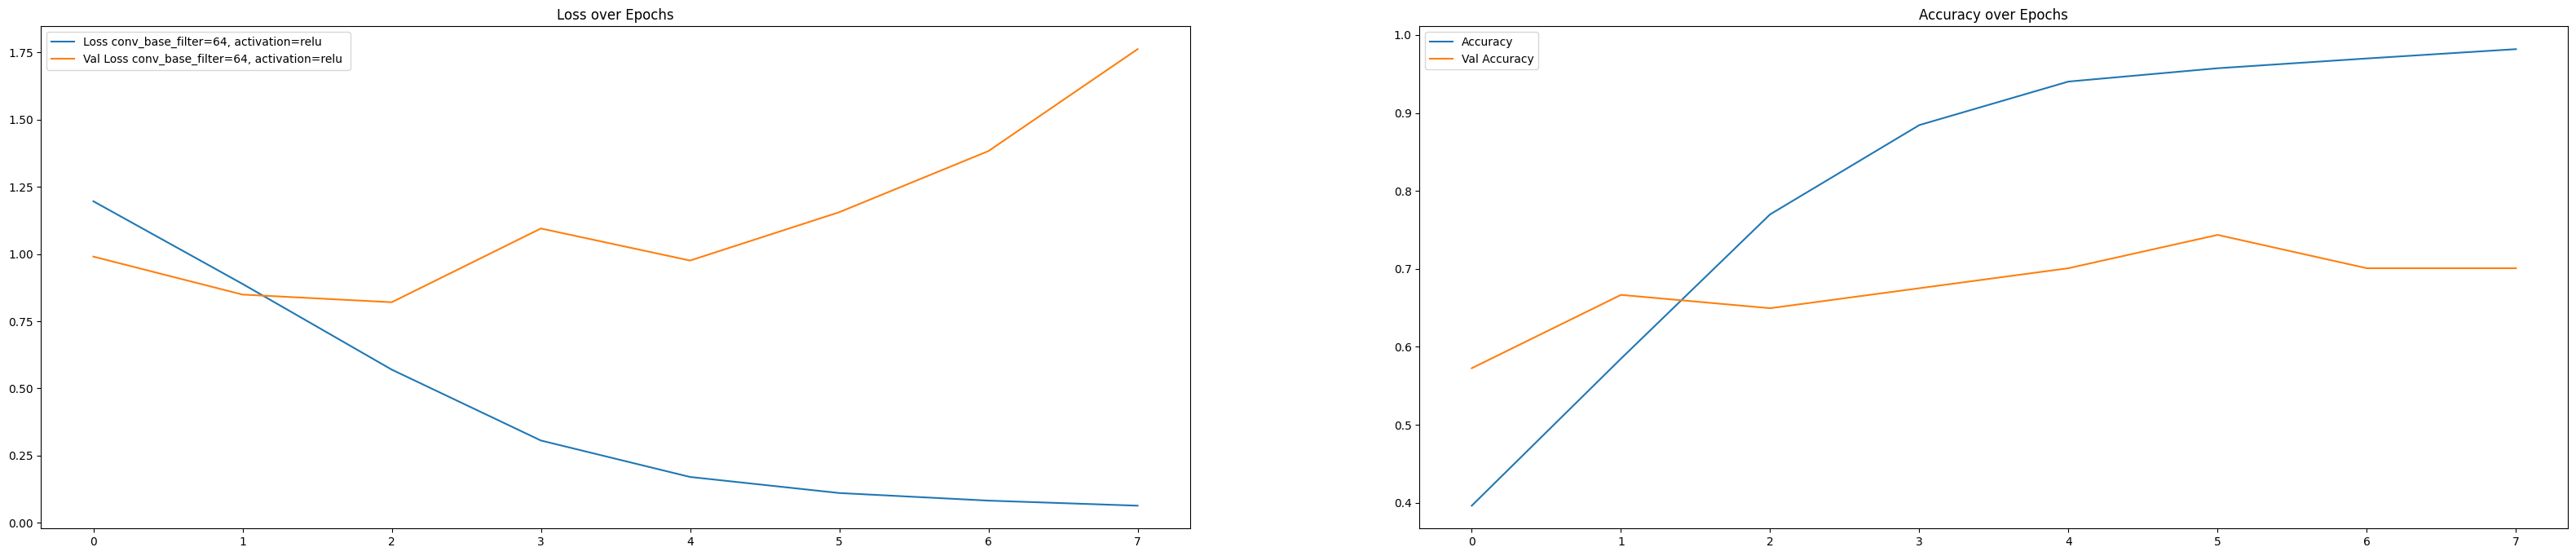

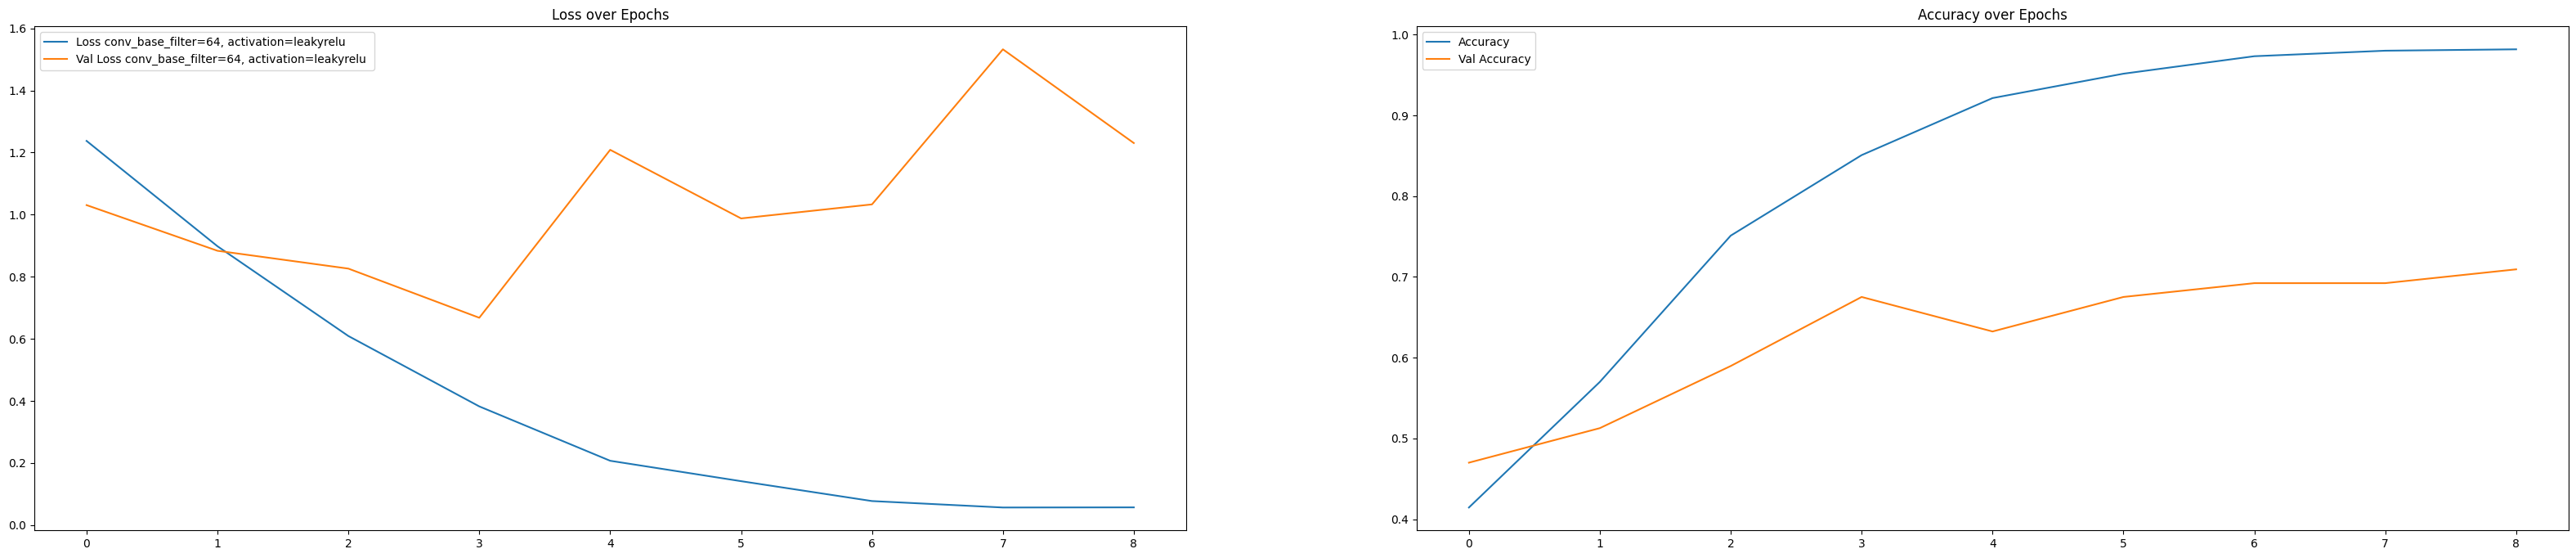

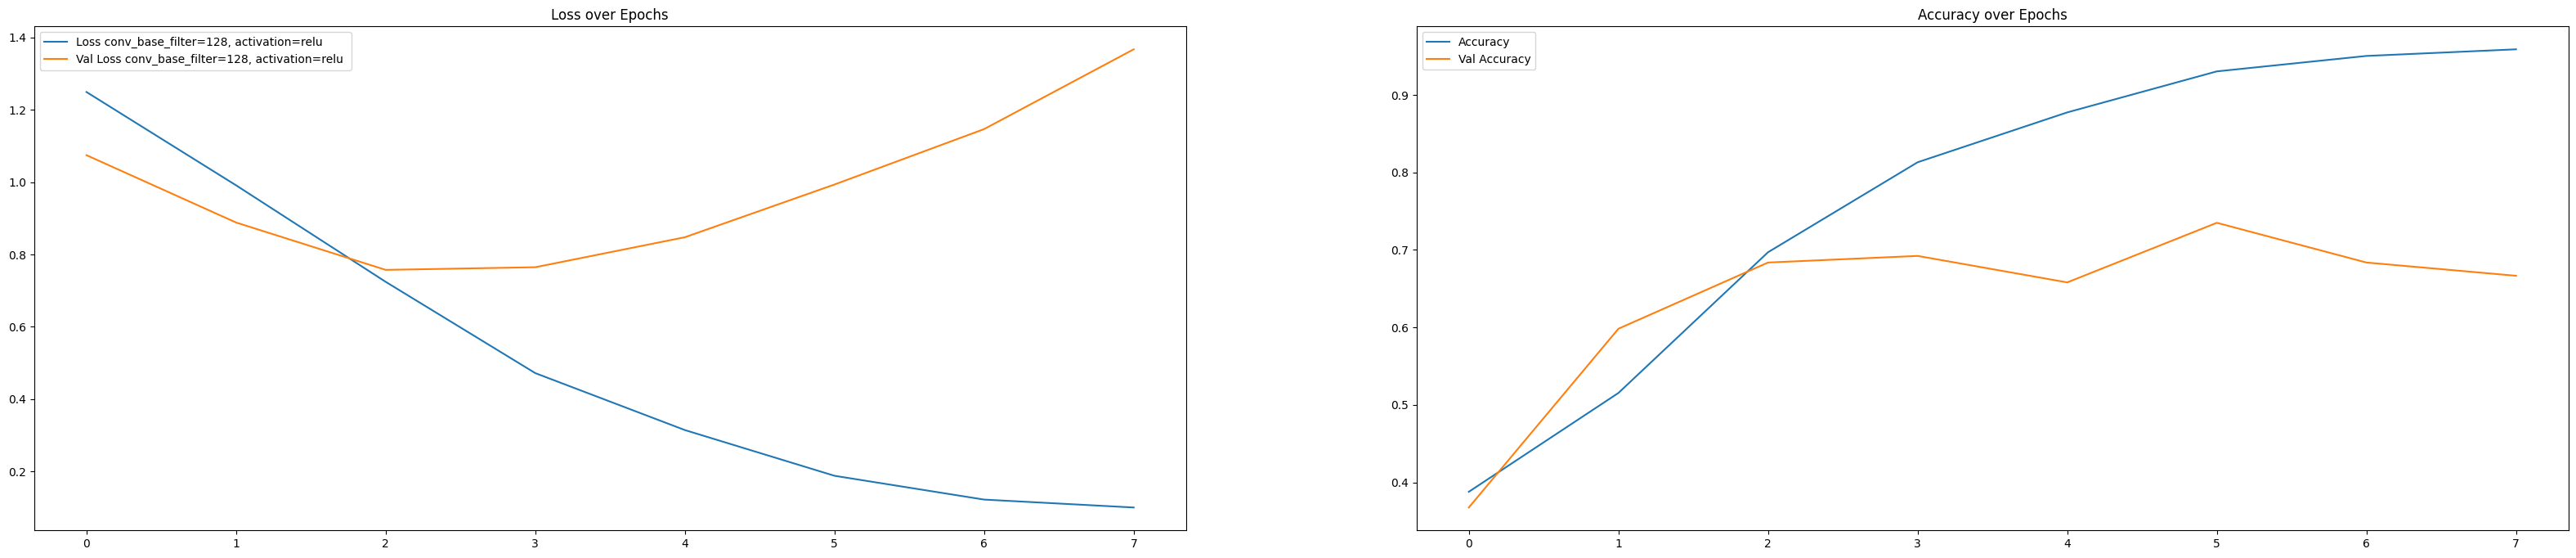

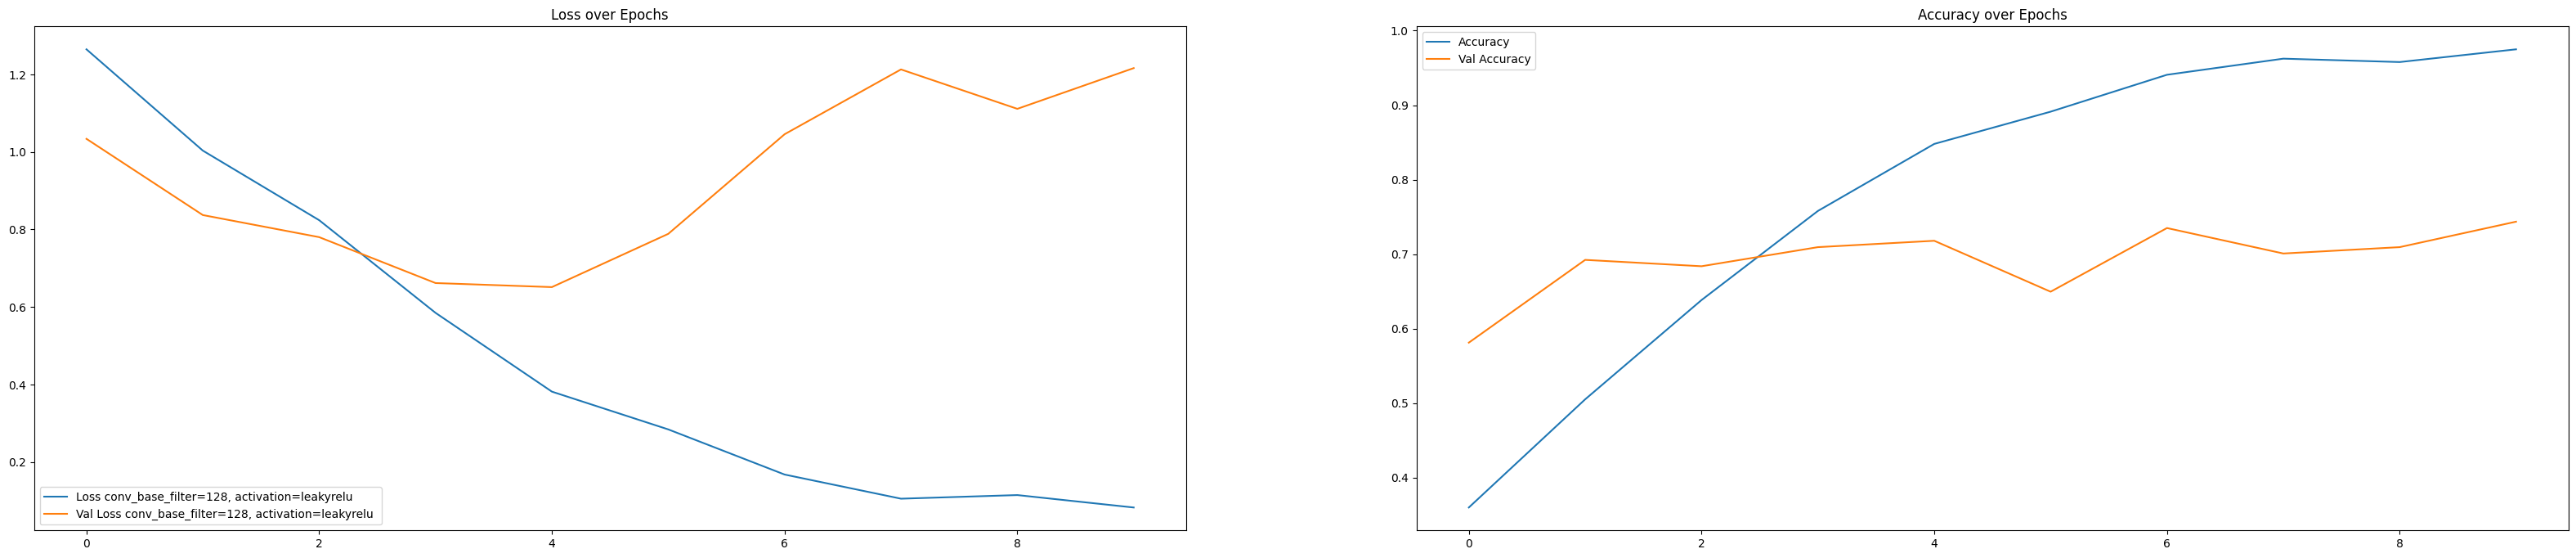

In [13]:
for label, history in histories:
    plt.figure(figsize=(40, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss '+label)
    plt.plot(history.history['val_loss'], label='Val Loss '+label)
    plt.legend()
    plt.title("Loss over Epochs")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy over Epochs")
    plt.show()



After running multiple experiments (see the picture below) both architectures with initial filters of 64 and 128 showed comparable validation performance. However, considering the training time, computational cost, and risk of overfitting on the relatively small BUSI dataset, the architecture with initial 64 filters was selected for fine-tuning. The choice balances model complexity with performance in a practical manner.


Let us try fine-tuning the model, with changing some parameters and adding small changes that could improve performance.

# 1. Small changes (different dropouts and initial kernels)

### Let us keep a history also for this model adjustments to see the plots

In [5]:
histories_leaky_128 = []

And now train the models

In [6]:
initial_kernels = [(3,3),(5,5)]
dropouts = [0.5, 0.6, 0.7]


for initial_kernel in initial_kernels:
    for dropout in dropouts:
        print(
                f"Training model with: "
                f"initial_kernel={initial_kernel}, "
                f"dropout={dropout}"
            )

        # Early stopping
        early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)


        # Model definition
        model = Sequential([
            Input(shape=(224, 224, 1)),
            Conv2D(64, kernel_size=initial_kernel, activation=(LeakyReLU(negative_slope=0.01))),
            MaxPooling2D(pool_size=(2, 2)),
        
            Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
            MaxPooling2D(pool_size=(2, 2)),
        
            Conv2D(128*2, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
            MaxPooling2D(pool_size=(2, 2)),
        
            Flatten(),
            Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
            Dropout(dropout),
            Dense(3, activation='softmax')
        ])
        
        # Compile
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Train
        history = model.fit(
            X_train_aug, y_train_aug,
            validation_data=(X_val, y_val),
            epochs=30,
            batch_size=32,
            callbacks=[early_stop]
        )
        
        # Save
        label = (
            f"initial_kernel={initial_kernel}, "
            f"dropout={dropout}"
        )
        histories_leaky_128.append((label, history))

Training model with: initial_kernel=(3, 3), dropout=0.5
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.3419 - loss: 1.1791 - val_accuracy: 0.5128 - val_loss: 1.0854
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.4397 - loss: 1.0574 - val_accuracy: 0.5983 - val_loss: 0.9116
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.5791 - loss: 0.9078 - val_accuracy: 0.4615 - val_loss: 1.0488
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7281 - loss: 0.6368 - val_accuracy: 0.6154 - val_loss: 1.0136
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8709 - loss: 0.3729 - val_accuracy: 0.7009 - val_loss: 0.7627
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9408 - loss: 0.1670 - val_accuracy: 0.7094 - val_loss: 0.9490
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9647 - loss: 0.0906 - val_accuracy: 0.6838 - val_loss: 0.9738
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 

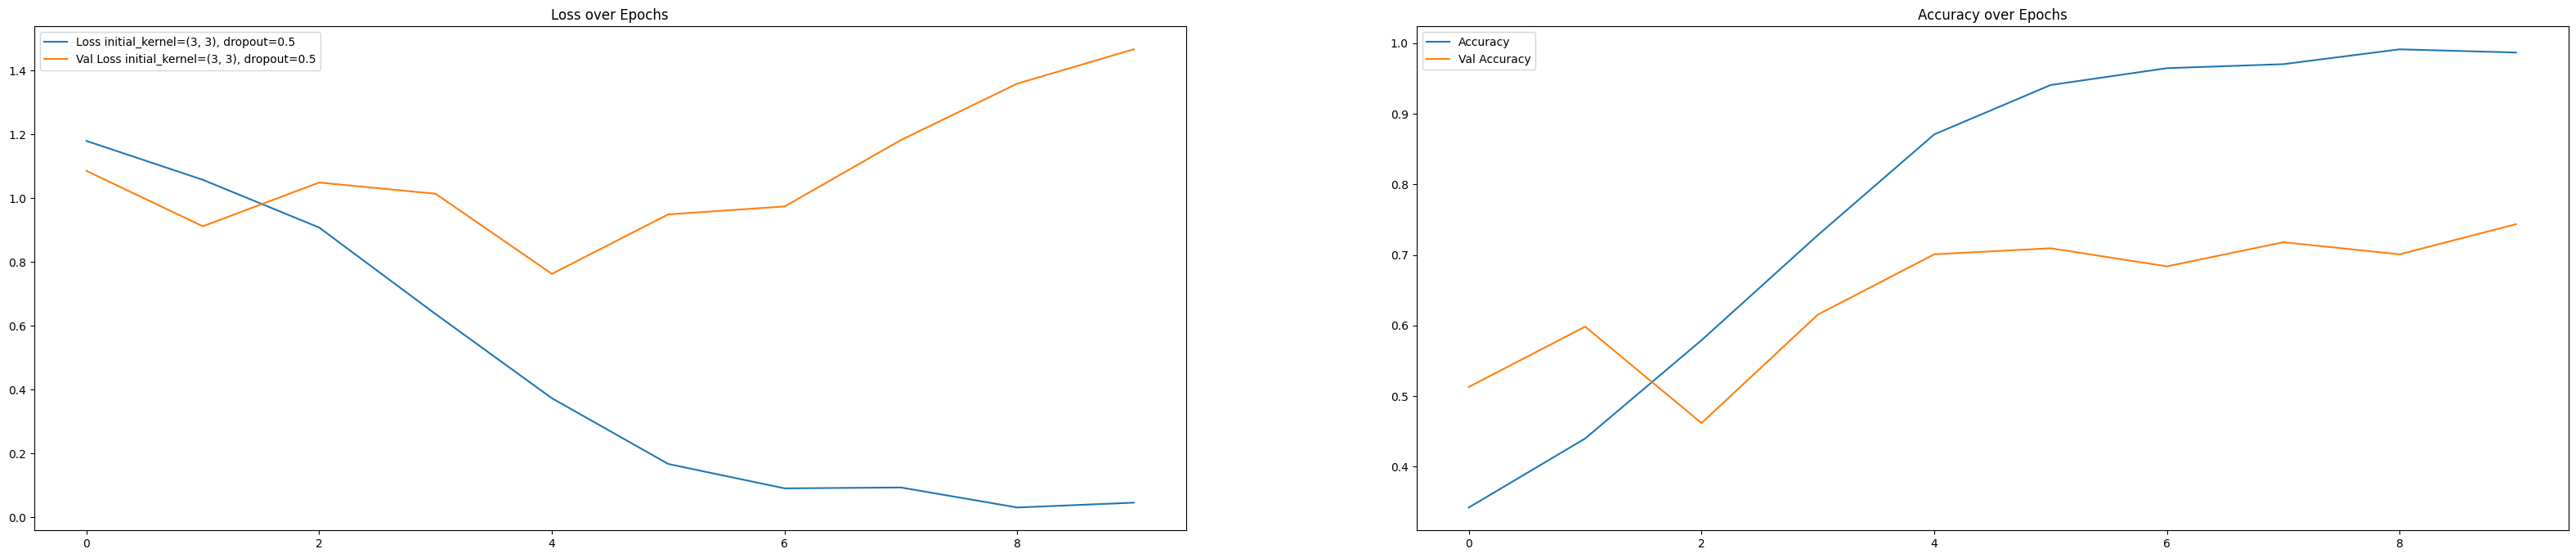

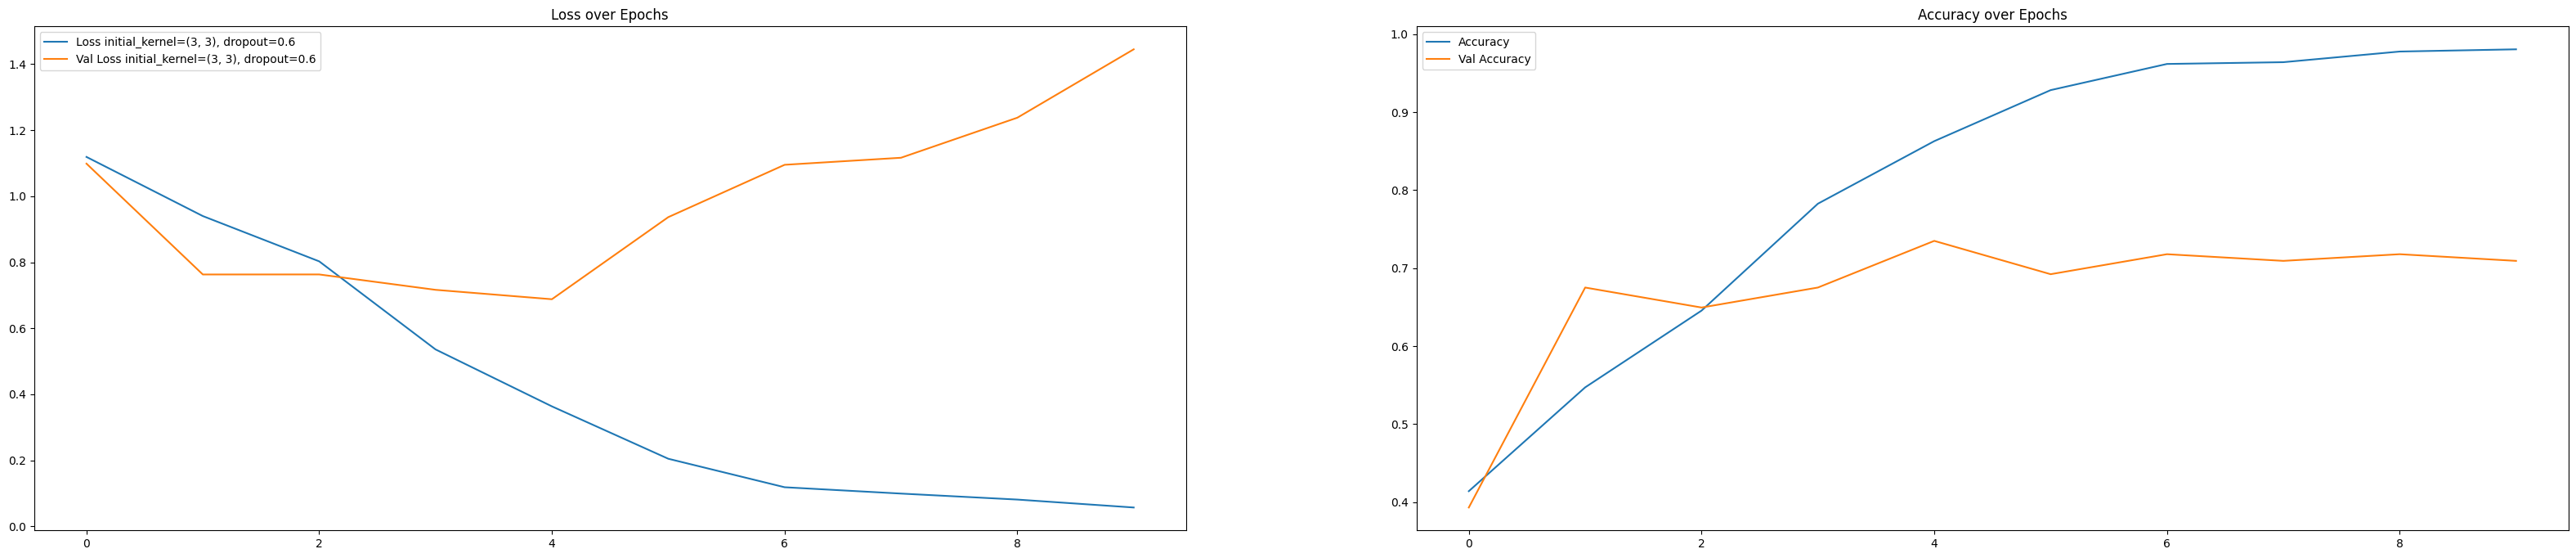

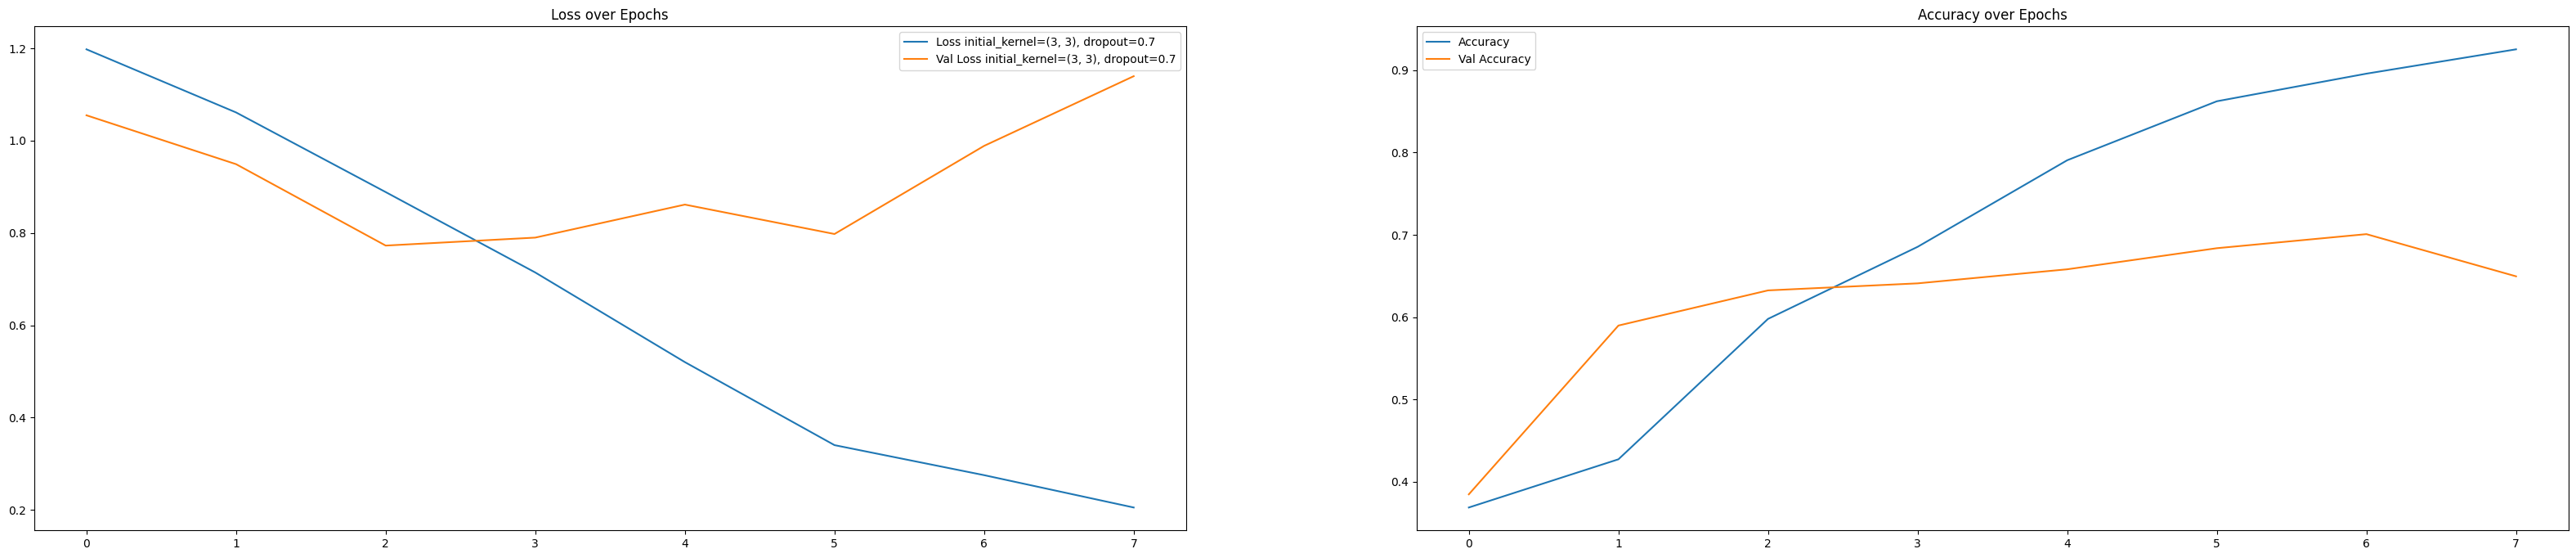

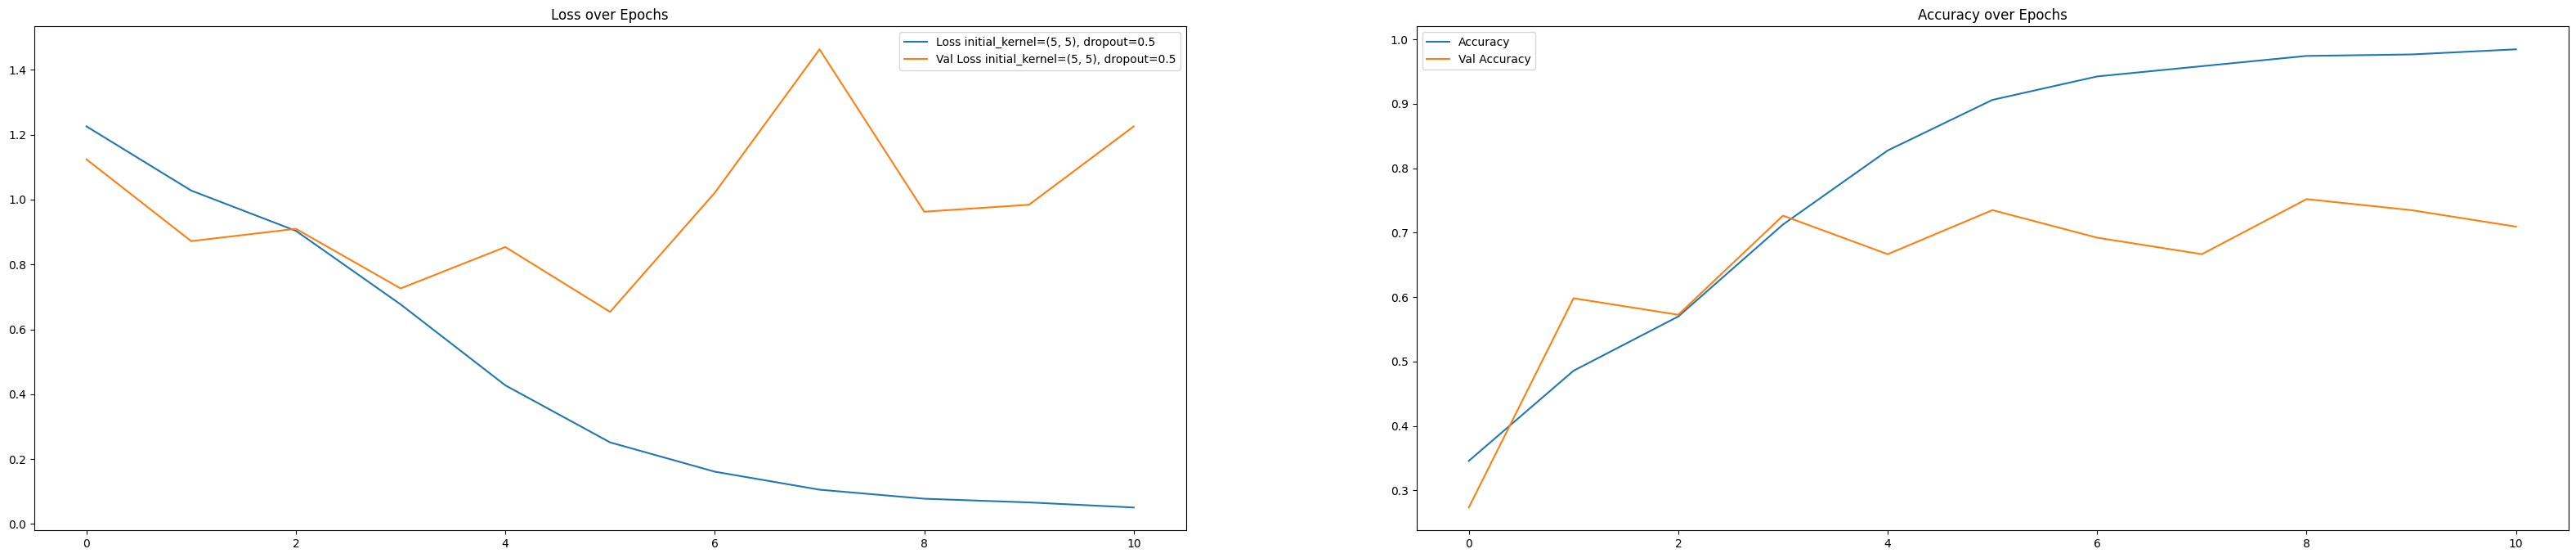

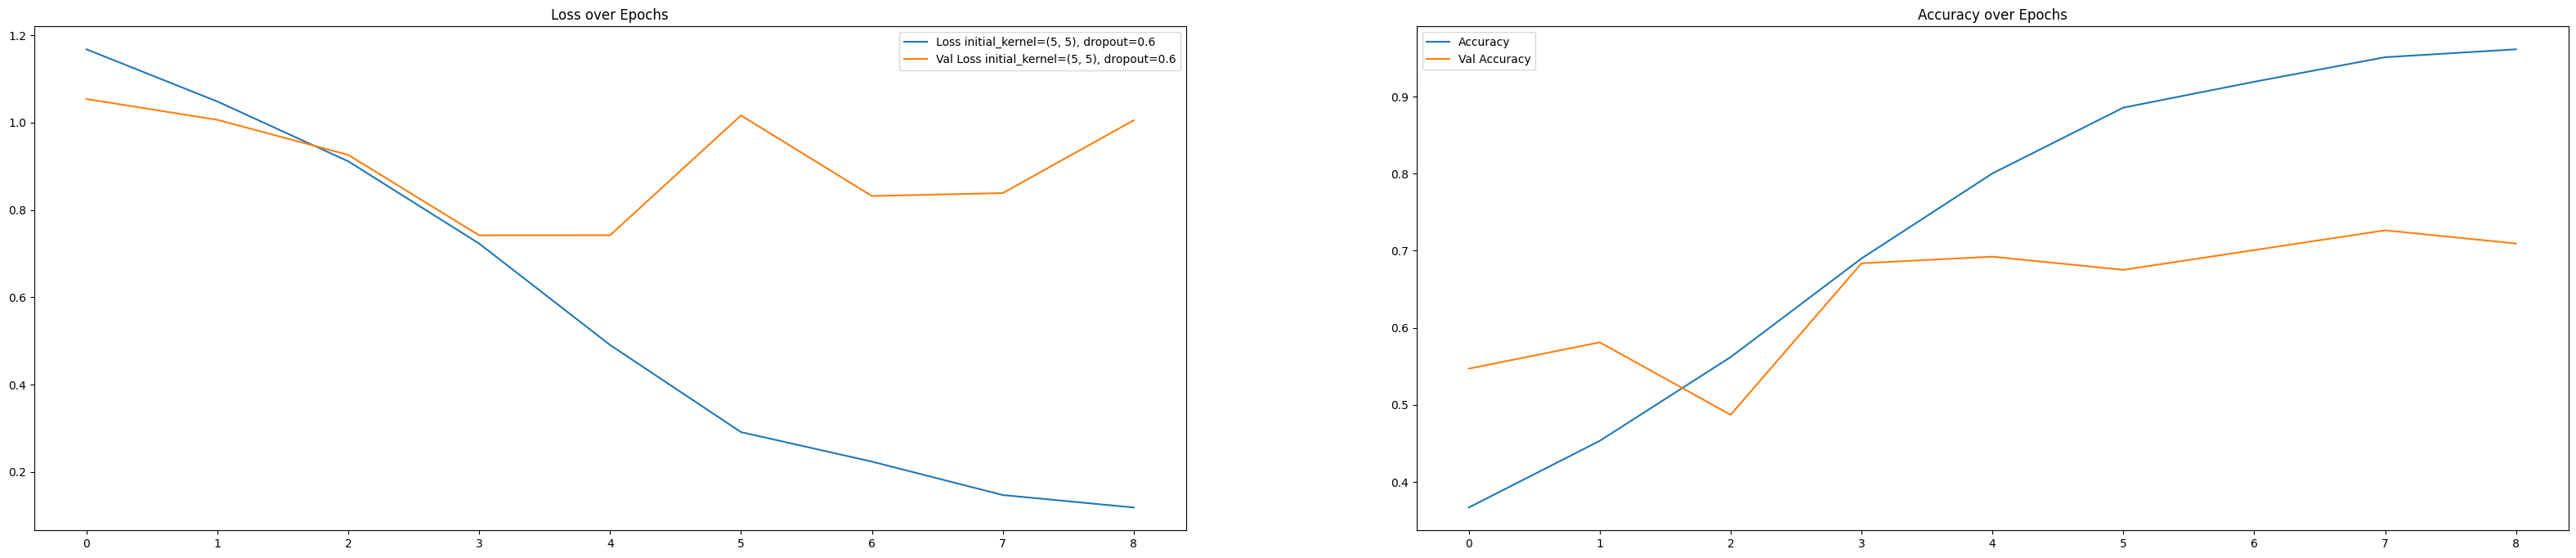

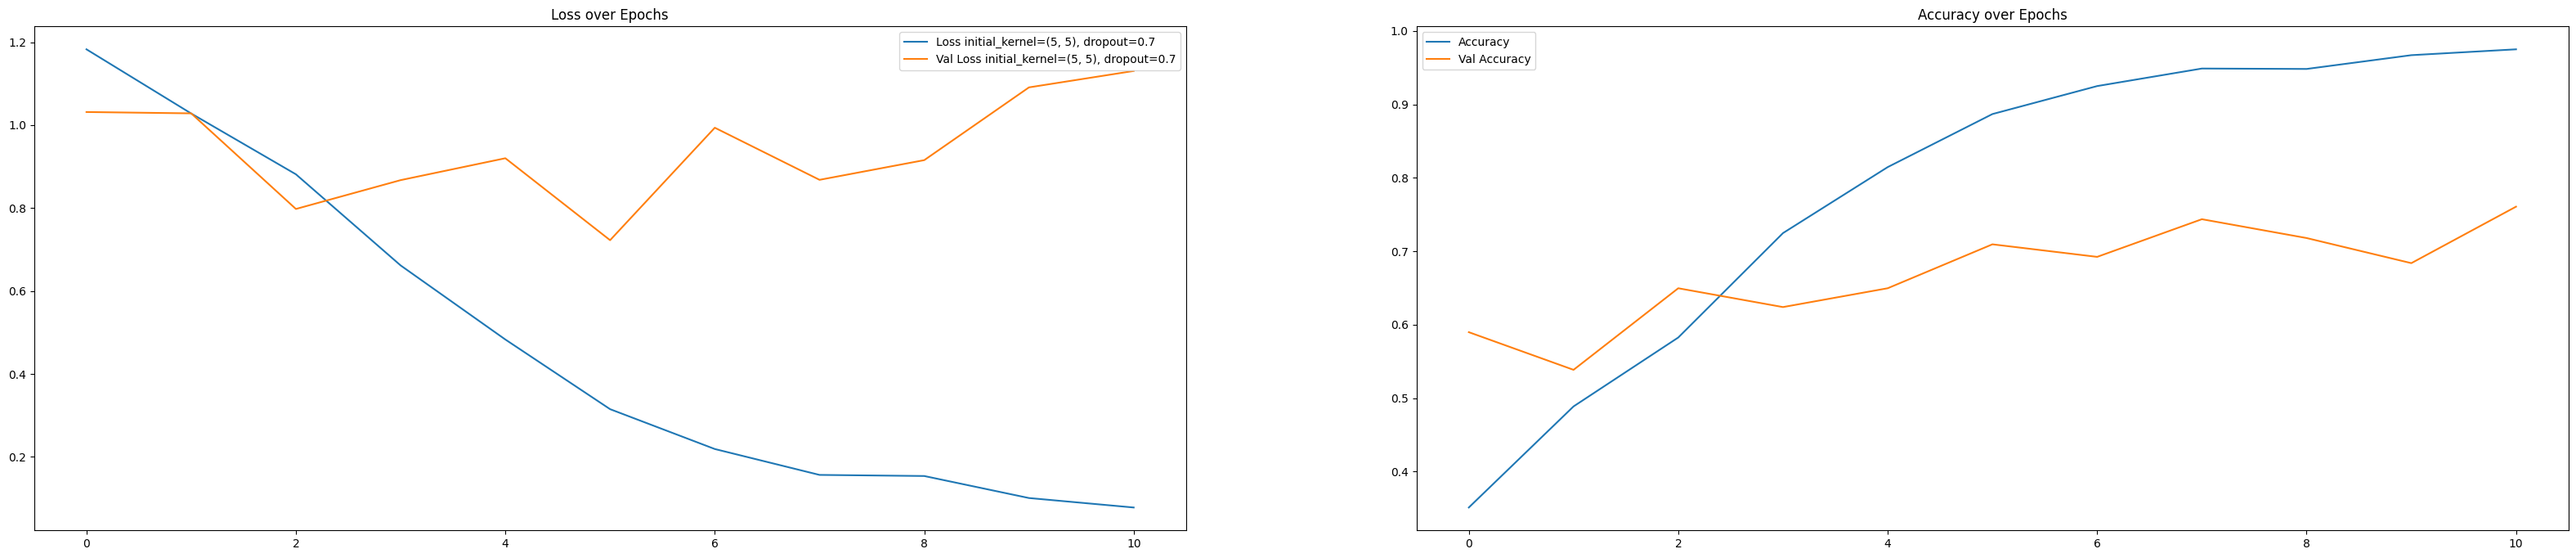

In [7]:
for label, history in histories_leaky_128:
    plt.figure(figsize=(40, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss '+label)
    plt.plot(history.history['val_loss'], label='Val Loss '+label)
    plt.legend()
    plt.title("Loss over Epochs")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy over Epochs")
    plt.show()



We can see that Training model with: initial_kernel=(5, 5), dropout=0.7 provides the best results. Now let us try to improve it with some advanced techniques.

To identify the optimal architecture, I conducted a grid search over different kernel sizes ((3×3), (5×5)) and dropout rates (0.5, 0.6, 0.7). After multiple runs, the model with an initial kernel size of (5×5) and dropout of 0.7 consistently yielded the highest validation accuracy, achieving a peak of 76.07% at epoch 6 before early stopping

In [8]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])

### Label Smoothing

Hard one-hot labels (like [0, 1, 0]) encourage the model to become overconfident, especially on small or noisy datasets. This leads to:
- Overfitting
- Poor generalization
- Bad calibration (predicted probabilities are extreme)

Label smoothing combats this by:
- Penalizing overconfidence
- Encouraging the model to be a little uncertain
- Improving generalization,

This is done by apply the formula:

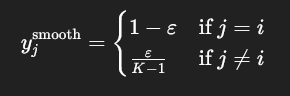

Where episilon = smoothing parameter

In [9]:
num_classes = 3  # Normal, Benign, Malignant
label_smoothing = 0.1

def smooth_labels(y, num_classes, smoothing=0.1):
    """
    Converts sparse labels to smoothed one-hot vectors.
    """
    y_one_hot = tf.one_hot(y, depth=num_classes)
    smooth_positives = 1.0 - smoothing
    smooth_negatives = smoothing / num_classes
    y_smooth = y_one_hot * smooth_positives + smooth_negatives
    return y_smooth


In [10]:
y_train_smooth = smooth_labels(y_train_aug, num_classes, label_smoothing)
y_val_smooth = smooth_labels(y_val, num_classes, label_smoothing)


**tf.keras.losses.CategoricalCrossentropydesigned** is used to compute the loss between two probability distributions — the predicted probabilities and the (smoothed) target, from_logits=False because the model ends in softmax.

In [11]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model_final.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

        
# Train
history = model_final.fit(
        X_train_aug, y_train_smooth,
        validation_data=(X_val, y_val_smooth),
        epochs=30,
        batch_size=32,
        callbacks=[early_stop]
        )

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.3367 - loss: 1.2223 - val_accuracy: 0.1709 - val_loss: 1.1041
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.4141 - loss: 1.0694 - val_accuracy: 0.4786 - val_loss: 1.0176
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5273 - loss: 0.9885 - val_accuracy: 0.6154 - val_loss: 0.8596
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6416 - loss: 0.8714 - val_accuracy: 0.6581 - val_loss: 0.8497
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7611 - loss: 0.7212 - val_accuracy: 0.6325 - val_loss: 0.8632
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8441 - loss: 0.6034 - val_accuracy: 0.6752 - val_loss: 0.8100
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8817 - loss: 0.5423 - val_accuracy: 0.6838 - val_loss: 0.7629
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9340 - loss: 0.4762 - val_accuracy: 0.6410 - val_loss:

### Learning Rate Scheduler

A *Learning Rate Scheduler* is a technique that automatically adjusts the learning rate during training, based on:
- the number of epochs, or
- the validation loss/accuracy, or
- some custom rule

Goal: Improve convergence by using higher learning rates at the beginning (fast learning) and lower learning rates later (fine-tuning).

In [12]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])

| Parameter  | Meaning                                                                 | Example                                                         |
| ---------- | ----------------------------------------------------------------------- | --------------------------------------------------------------- |
| `monitor`  | The metric to watch (usually `'val_loss'` or `'val_accuracy'`)       | `'val_loss'` means reduce LR if validation loss doesn’t improve |
| `factor`   | The **multiplicative factor** to reduce the learning rate by            | `factor=0.5` → new LR = old LR × 0.5                            |
| `patience` | Number of **epochs with no improvement** before reducing LR             | `patience=3` → wait 3 epochs before reducing LR                 |
| `verbose`  | Whether to print updates                                                | `1` = print when LR changes, `0` = silent                       |
| `min_lr`   | The **minimum learning rate** the scheduler can reach                   | Prevents LR from going too low (e.g. `1e-6`)                    |


In [16]:
# Learning rate scheduler
reduce_lr_1 = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

reduce_lr_3 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


# Compile your model
model_final.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



## Default

In [17]:
# Train with callbacks
history = model_final.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr_1]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.3436 - loss: 1.1853 - val_accuracy: 0.5641 - val_loss: 1.0556 - learning_rate: 0.0010
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4539 - loss: 1.0539 - val_accuracy: 0.5641 - val_loss: 0.9938 - learning_rate: 0.0010
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5421 - loss: 0.9480 - val_accuracy: 0.5983 - val_loss: 0.8504 - learning_rate: 0.0010
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6451 - loss: 0.8058 - val_accuracy: 0.6752 - val_loss: 0.7490 - learning_rate: 0.0010
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7486 - loss: 0.5974 - val_accuracy: 0.7350 - val_loss: 0.6792 - learning_rate: 0.0010
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8504 - loss: 0.3946 - val_accuracy: 0.7009 - val_loss: 0.7968 - learning_rate: 0.0010
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8999 - loss: 0.2878 - val_accuracy: 

## More aggressive decay

In [18]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])

# Compile your model
model_final.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Train with callbacks
history = model_final.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr_2]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3430 - loss: 1.2078 - val_accuracy: 0.4530 - val_loss: 1.0754 - learning_rate: 0.0010
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4198 - loss: 1.0687 - val_accuracy: 0.5726 - val_loss: 0.9827 - learning_rate: 0.0010
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5137 - loss: 0.9721 - val_accuracy: 0.5043 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6064 - loss: 0.8463 - val_accuracy: 0.6752 - val_loss: 0.8567 - learning_rate: 0.0010
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7019 - loss: 0.7024 - val_accuracy: 0.7436 - val_loss: 0.6376 - learning_rate: 0.0010
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7833 - loss: 0.5369 - val_accuracy: 0.6239 - val_loss: 0.8558 - learning_rate: 0.0010
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8441 - loss: 0.4049 - val_accuracy: 

## More patient and less aggressive

In [20]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])

# Compile your model
model_final.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
# Train with callbacks
history = model_final.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr_3]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3641 - loss: 1.1926 - val_accuracy: 0.5812 - val_loss: 1.0493 - learning_rate: 0.0010
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.4556 - loss: 1.0492 - val_accuracy: 0.5470 - val_loss: 1.0153 - learning_rate: 0.0010
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5210 - loss: 0.9568 - val_accuracy: 0.5983 - val_loss: 0.9013 - learning_rate: 0.0010
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5967 - loss: 0.8741 - val_accuracy: 0.6496 - val_loss: 0.7719 - learning_rate: 0.0010
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7304 - loss: 0.6572 - val_accuracy: 0.6410 - val_loss: 0.7458 - learning_rate: 0.0010
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8197 - loss: 0.4754 - val_accuracy: 0.6838 - val_loss: 0.7599 - learning_rate: 0.0010
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8692 - loss: 0.3425 - val_accuracy: 

### Cosine Annealing (Special Type of Learning Rate Scheduler)

Cosine Annealing is a learning rate scheduler that gradually decreases the learning rate following a cosine curve.

In [22]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])


In [7]:
# Base setup
lr_schedule_1 = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=30 * len(X_train_aug),  # for 30 epochs
    alpha=1e-5
)

# Slower decay (higher alpha)
lr_schedule_2 = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=30 * len(X_train_aug),
    alpha=0.1  # final LR = 10% of initial
)

# Start slower but decay more
lr_schedule_3 = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-4,
    decay_steps=30 * len(X_train_aug),
    alpha=0.01
)

# Decay slower, over more steps
lr_schedule_4 = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=40 * len(X_train_aug),  # longer decay
    alpha=1e-5
)




In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_1)

# Compile 
model_final.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 
# Train
history = model_final.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.3549 - loss: 1.1847 - val_accuracy: 0.5641 - val_loss: 1.0445
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.4005 - loss: 1.0835 - val_accuracy: 0.5983 - val_loss: 0.9883
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5017 - loss: 1.0069 - val_accuracy: 0.6068 - val_loss: 0.8393
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5899 - loss: 0.8756 - val_accuracy: 0.6838 - val_loss: 0.7642
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.6689 - loss: 0.7445 - val_accuracy: 0.6838 - val_loss: 0.7679
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8015 - loss: 0.5002 - val_accuracy: 0.7094 - val_loss: 0.7470
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.8720 - loss: 0.3526 - val_accuracy: 0.7094 - val_loss: 0.7082
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9141 - loss: 0.2455 - val_accuracy: 0.7094 - val_loss:

In [25]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_2)

# Compile
model_final.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 
# Train
history = model_final.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.3601 - loss: 1.2212 - val_accuracy: 0.5556 - val_loss: 1.0730
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4619 - loss: 1.0333 - val_accuracy: 0.4872 - val_loss: 0.9565
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5421 - loss: 0.9341 - val_accuracy: 0.5556 - val_loss: 0.8842
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6638 - loss: 0.7708 - val_accuracy: 0.6667 - val_loss: 0.7448
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7645 - loss: 0.5982 - val_accuracy: 0.7094 - val_loss: 0.8014
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8527 - loss: 0.3826 - val_accuracy: 0.6325 - val_loss: 0.7200
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9044 - loss: 0.2570 - val_accuracy: 0.6923 - val_loss: 0.7959
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9369 - loss: 0.1807 - val_accuracy: 0.7265 - val_loss:

In [27]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_3)

# Compile
model_final.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 
# Train
history = model_final.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.3544 - loss: 1.1239 - val_accuracy: 0.5128 - val_loss: 1.0665
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5228 - loss: 0.9835 - val_accuracy: 0.6410 - val_loss: 0.9246
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6638 - loss: 0.7708 - val_accuracy: 0.6838 - val_loss: 0.8120
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7850 - loss: 0.5575 - val_accuracy: 0.6496 - val_loss: 0.6975
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8641 - loss: 0.3731 - val_accuracy: 0.6239 - val_loss: 0.8539
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9078 - loss: 0.2459 - val_accuracy: 0.7094 - val_loss: 0.7547
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9397 - loss: 0.1813 - val_accuracy: 0.7436 - val_loss: 0.7360
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9562 - loss: 0.1315 - val_accuracy: 0.7009 - val_loss:

In [8]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_4)

# Compile
model_final.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 
# Train
history = model_final.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3504 - loss: 1.3273 - val_accuracy: 0.5556 - val_loss: 1.0411
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3709 - loss: 1.0917 - val_accuracy: 0.5983 - val_loss: 1.0143
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4784 - loss: 1.0229 - val_accuracy: 0.5641 - val_loss: 0.9324
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.5176 - loss: 1.0002 - val_accuracy: 0.4957 - val_loss: 0.9944
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5620 - loss: 0.9123 - val_accuracy: 0.6068 - val_loss: 0.8251
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6013 - loss: 0.8413 - val_accuracy: 0.6410 - val_loss: 0.7810
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7008 - loss: 0.6888 - val_accuracy: 0.6752 - val_loss: 0.7183
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7850 - loss: 0.5038 - val_accuracy: 0.6923 - val_loss:

## Final choices

We have 4 choices: 

    - 1. simple model_final 
    
    - 2. model_final with aggressive decay
    
    - 3. model_final with lr_schedule_1 = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=30 * len(X_train_aug),  # for 30 epochs
    alpha=1e-5)

    - 4. model_final with lr_schedule_4 = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=40 * len(X_train_aug),  # longer decay
    alpha=1e-5
)

Although Model 2 had slightly better validation accuracy and lower loss, all 4 models reached comparable performance levels. Therefore, further evaluation using metrics such as precision, recall, F1-score, and confusion matrix was conducted to ensure fairness and robustness, especially considering the clinical importance of avoiding false negatives. -> see the next notebook